In [2]:
import jax
from jax import random
from jax import numpy as jnp

from localdynamics import derivative, local_dynamics
from localdynamics.plotting import plot

from matplotlib import pyplot as plt

jax.config.update('jax_platforms', 'cpu')
jax.config.update("jax_default_device", jax.devices('cpu')[0])

# Generate dummy data

In [3]:
# Is mostly O(1) in variables_dim and number_datasets but scales poorly with time_dim
# max time_dim tried : 1000
number_datasets, time_dim, variables_dim = 3, 101, 200

xs = [random.normal(k, (time_dim, variables_dim)) for k in random.split(random.key(0), number_datasets)]
ts = [jnp.linspace(0, 1, time_dim+1)[:, jnp.newaxis]]*number_datasets

# Compute the singular values

The analysis depends on three key hyperparameters: the number of neighboring points, whether we rescale the dynamics to unit length, and whether if scale the dynamics by their distance to the central point.

In [4]:
# Finite difference dynamics
dxs_dts = [derivative(t[1:]-t[:-1], x, accuracy=2) for t, x in zip(ts, xs)]

# Dynamics near each point (i.e. local dynamics)
# number_of_neighbors scales O(number_of_neighbors)
local_dxs_dts = [local_dynamics(x, dx_dt, number_of_neighbors=50, unit_length=True, distance_scaling=1.0) for x, dx_dt in zip(xs, dxs_dts)]
local_xs = [local_dynamics(x, x, number_of_neighbors=50, unit_length=True, distance_scaling=1.0) for x, dx_dt in zip(xs, dxs_dts)]

# Singular values of the local dynamics
sv_local_dxs_dts = [[jnp.linalg.svd(local_dx_dt[..., :k, :], full_matrices=False)[1] for local_dx_dt in local_dxs_dts] for k in range(1, 50)]

# We also compute the singular values of the full data
sv_xs = [jnp.linalg.svd(x, full_matrices=False)[1] for x in local_xs]

# Plotting

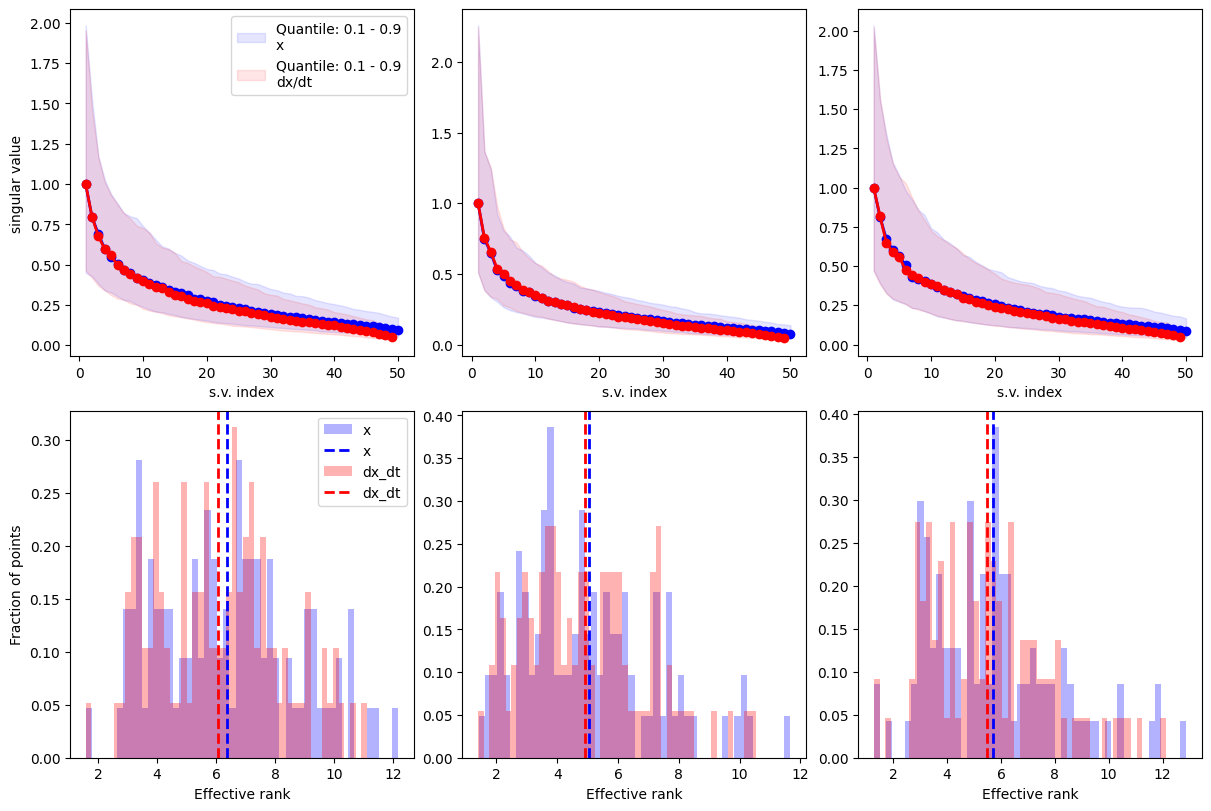

In [9]:
fig, axs = plot.get_axes_grid(cols=number_datasets, rows=2, dpi=100)

plot.plot_spectra(axs[:, 0], sv_xs, log=False, normalize=True, quantile=0.1, plotall=False, color='blue', label='x')

plot.plot_spectra(axs[:, 0], sv_local_dxs_dts[-1], log=False, normalize=True, quantile=0.1, plotall=False, color='red', label='dx/dt')

plot.plot_effective_rank(axs[:, 1], sv_xs, color='blue', label='x')
plot.plot_effective_rank(axs[:, 1], sv_local_dxs_dts[-1], color='red', label='dx_dt')

plt.show()